In [15]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [13]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 50, 50 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 3 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [17]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [18]:
train=train_generator
val=validation_generator
test=test_generator

In [39]:
from keras.applications import MobileNet
from keras.models import Model 
import keras 
import tensorflow as tf

mobilnet = tf.keras.applications.MobileNet(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

mobilnet.trainable=True

In [ ]:
#for layer in Xception_model.layers[:-40]:
#    layer.trainable = False

In [40]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in mobilnet.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001D3EEA93C88>,input_10,True
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001D3EE0B6CC8>,conv1_pad,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D3F048D2C8>,conv1,True
3,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D3F0518E08>,conv1_bn,True
4,<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x000001D3F0528E48>,conv1_relu,True
...,...,...,...
82,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D3F1E36C88>,conv_dw_13_bn,True
83,<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x000001D3F1E3B748>,conv_dw_13_relu,True
84,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D3F1E3E188>,conv_pw_13,True
85,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D3F1E94708>,conv_pw_13_bn,True


In [41]:
mobilnet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 51, 51, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 25, 25, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 25, 25, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 25, 25, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 25, 25, 32) 

In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [35]:
from os import listdir
from os.path import isfile,isdir, join
import numpy

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from keras.optimizers import RMSprop 
from sklearn.model_selection import train_test_split

In [48]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from keras.models import Sequential 
from keras import optimizers 

# build model architecture 
model = tf.keras.Sequential()
model.add(mobilnet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_class, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1, 1, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [49]:
history = model.fit_generator(train, steps_per_epoch=100, 
                              epochs=50,  
                              validation_data=val,   
                              validation_steps=50,  
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/50
100/100 [==============================] - 8s 78ms/step - loss: 0.8329 - accuracy: 0.7182 - val_loss: 0.7106 - val_accuracy: 0.8519
Epoch 2/50
100/100 [==============================] - 5s 51ms/step - loss: 0.6697 - accuracy: 0.8908 - val_loss: 0.6888 - val_accuracy: 0.8637
Epoch 3/50
100/100 [==============================] - 5s 52ms/step - loss: 0.6574 - accuracy: 0.8963 - val_loss: 0.6778 - val_accuracy: 0.8737
Epoch 4/50
100/100 [==============================] - 5s 52ms/step - loss: 0.6516 - accuracy: 0.9053 - val_loss: 0.6754 - val_accuracy: 0.8744
Epoch 5/50
100/100 [==============================] - 5s 51ms/step - loss: 0.6491 - accuracy: 0.9050 - val_loss: 0.6761 - val_accuracy: 0.8725
Epoch 6/50
100/100 [==============================] - 5s 52ms/step - loss: 0.6373 - accuracy: 0.9175 - val_loss: 0.6689 - val_accuracy: 0.8819
Epoch 7/50
100/100 [=============================

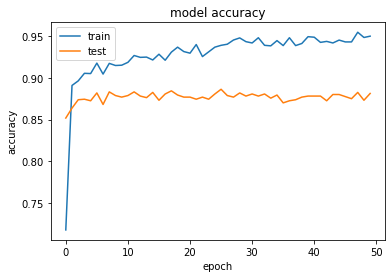

In [50]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

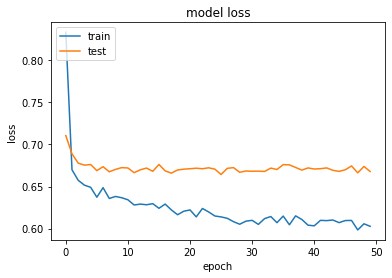

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

  ...
    to  
  ['...']
213/213 [==============================] - 7s 34ms/step - loss: 0.6509 - accuracy: 0.8975
El modelo predice el  89.74661231040955 % de los datos
